In [1]:
! nvidia-smi

Sat Dec  2 10:35:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 本笔记为VGG的介绍和实现

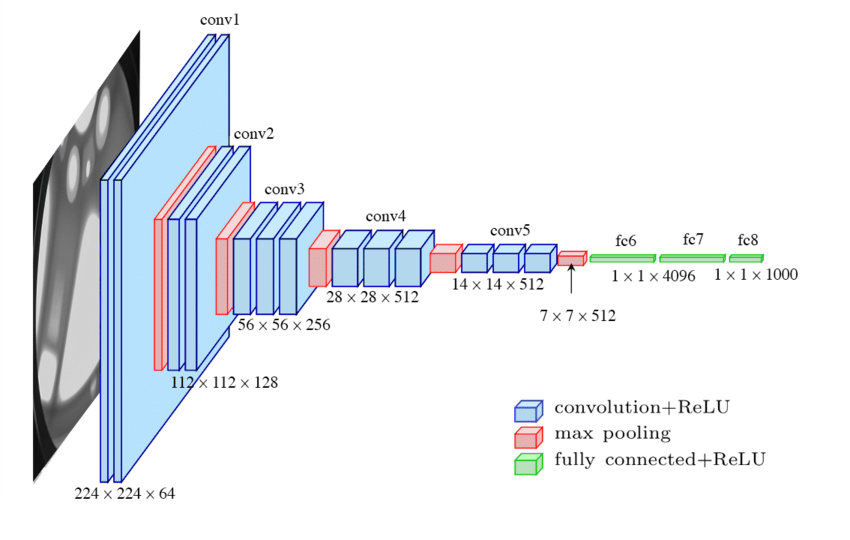

VGG：小卷积核，卷积块，通道增加，减少使用全连接层

在我们知到卷积操作的各种优点后，我们进一步发现：

大卷积核的感受野大，即可以辐射到的输入范围大，提取到的特征更加宏观，但是大卷积核的参数量也多，以2维卷积为例，其参数数量是二次方指数级增长的
但是研究人员发现，使用多个小卷积核卷积，可以得到与大卷积核相同的感受野，而且参数数量更少：

1个5x5卷积核（参数数量5x5+1）=2个3x3卷积核（参数数量2x3x3+1）

1个3x3卷积核=1x3卷积核+3x1卷积核

如图：


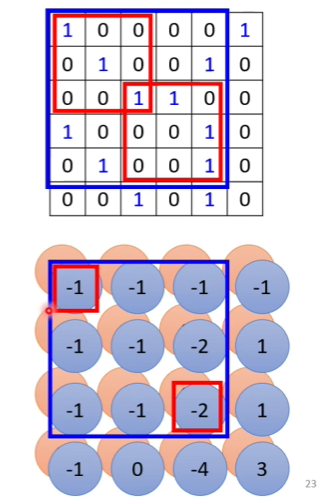

所以如果我们使用小卷积核3x3，1x1，并且扩展网络的深度，可以有效降低参数数量，并且因为使用多个小卷积核会扩展网络深度，每一次卷积后都会进如激活函数，我们会进行更多的激活操作，还能提高网络的表达能力（非线性能力）。

另一方面，研究人员还在其中引入了“块”，即多个卷积激活池化等操作封装在一起，并在设计更深的网络的过程中，重复使用此“块”的操作。

逐步增加网络的通道数来提高表达能力，早期的卷积层逐步增加通道数(64->128->256->512)，增加网络通道数也是提高表达能力的一个途径。

所以VGG与AlexNet的主要区别就是，使用小卷积核3x3

## **model**

In [ ]:
import torch

# 官方的vgg块的预训练权重
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
}
# 搭建的四种VGG网络各自的的卷积环节的配置：
cfgs = {
    # 数字64表示卷积核个数，M表示池化层结构（因为所有卷积核大小都是使用的3*3）
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

'''搭建网络模型'''


class VGG(torch.nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512 * 7 * 7, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes)
        )
        # 参数初始化
        if init_weights:
            self._initialize_weights()

    def forward(self, x):  # x: [batch,3,224,224]
        x = self.features(x)  # [batch,512,7,7]
        # torch.flatten展平操作 参数start_dim=1从第几个维度开始展平
        x = torch.flatten(x, start_dim=1) #  [batch,512*7*7]
        x = self.classifier(x)  # 分类
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                torch.nn.init.constant_(m.bias, 0)


# 搭建VGG层函数
def make_features(cfg: list): # 按照cfg中的参数配置VGG层
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":  # 根据M创建最大池化
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        else:  # 根据数字来创建卷积层
            conv2d = torch.nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, torch.nn.ReLU(True)]
            in_channels = v  # 在循环中，次层的out_channels为下一层的out_channels数
    return torch.nn.Sequential(*layers)  # *:非关键字传入
    # nn.Sequential函数定义中，将非关键字参数传入Sequential可以生成一个新的网络结构


# 通过函数实例化创建完整VGG网络
def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model



## **train**

In [ ]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data'
model = 'vgg16' # 'vgg11' 'vgg13' 'vgg16' 'vgg19'
mandate = 'flower'  # 'flower' 'hand'
save_path = model + '-' + mandate + '.pth'
init_weights = True
batch_size = 32
learning_rate = 0.0001
num_epoch = 30


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                        transforms.RandomHorizontalFlip(),  # 随机水平翻转
                        transforms.ToTensor(),  # 图像转换成tensor格式
                        transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "val": transforms.Compose([transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    data = mandate + '_data'
    image_path = os.path.join(data_root, data)  # 'D:/data/hand_data' 'D:/data/flower_data'
    # 确认文件路径存在
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format(data,model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                        transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                        transform=data_transform["val"])
    val_num = len(validate_dataset)
    print("using {} images for training, {} images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True,
                        num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                        batch_size=batch_size, shuffle=False,
                        num_workers=nw)

    '''设置网络'''
    num_classes = 6 if mandate == 'hand' else 5
    net = vgg(model_name=model, num_classes=num_classes, init_weights=init_weights)
    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器
    best_acc = 0.0  # 最佳准确率
    for epoch in range(num_epoch):
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)

        '''计算在测试集的准确率'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num  # 统计训练过程的平均损失
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / len(train_loader), val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == "__main__":
    main()


using cuda:0 device.
working in flower_data by vgg16
using 3306 images for training, 364 images for validation.
Using 2 dataloader workers every process
100%|██████████| 12/12 [01:15<00:00,  6.32s/it]
[epoch 1] train_loss: 1.435  val_accuracy: 0.357
100%|██████████| 12/12 [00:02<00:00,  4.66it/s]
[epoch 2] train_loss: 1.326  val_accuracy: 0.393
100%|██████████| 12/12 [00:02<00:00,  4.92it/s]
[epoch 3] train_loss: 1.314  val_accuracy: 0.431
100%|██████████| 12/12 [00:02<00:00,  4.86it/s]
[epoch 4] train_loss: 1.302  val_accuracy: 0.418
100%|██████████| 12/12 [00:02<00:00,  4.77it/s]
[epoch 5] train_loss: 1.283  val_accuracy: 0.456
100%|██████████| 12/12 [00:02<00:00,  4.83it/s]
[epoch 6] train_loss: 1.255  val_accuracy: 0.497
100%|██████████| 12/12 [00:02<00:00,  4.55it/s]
[epoch 7] train_loss: 1.224  val_accuracy: 0.516
100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
[epoch 8] train_loss: 1.176  val_accuracy: 0.484
100%|██████████| 12/12 [00:03<00:00,  3.09it/s]
[epoch 9] train_loss: 1

## test

class: daisy        prob: 0.128
class: dandelion    prob: 0.064
class: roses        prob: 0.322
class: sunflowers   prob: 0.0324
class: tulips       prob: 0.453


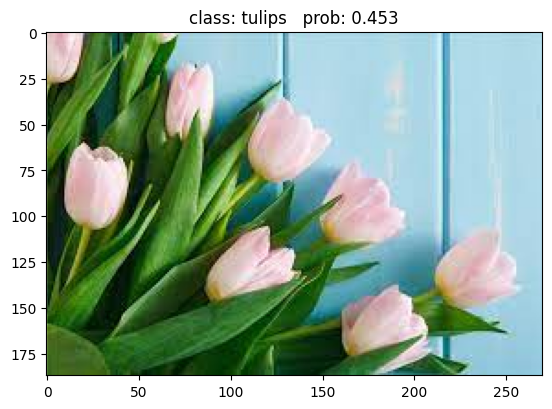

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

img_path = "/content/gdrive/MyDrive/Data/TestImage/f2.jpg"
weights_path = "/content/vgg16-flower.pth"
num_classes = 5   # flower 5  hand 6


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # load image
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    img = data_transform(img)# [N, C, H, W]
    img = torch.unsqueeze(img, dim=0)# expand batch dimension

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # create model
    model = vgg(model_name="vgg16", num_classes=num_classes).to(device)

    # load model weights
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        '''
        img.to(device) 将张量移动到指定device。
        model(img) 在device上运行模型。
        torch.squeeze 消除无用的单维度,主要是batch维度
        .cpu() 将张量移回CPU，进行后续的操作
        '''
        predict = torch.softmax(output, dim=0)      # 将分类结果转换成类别概率
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()


# x-ray数据集

## model

In [3]:
import torch

# 官方的vgg块的预训练权重
model_urls = {
        'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
        'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
        'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
        'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
    }
# 搭建的四种VGG网络各自的的卷积环节的配置
cfgs = {
    # 数字64表示卷积核个数，M表示池化层结构（因为所有卷积核大小都是使用的3*3）
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

'''搭建网络模型'''


class VGG(torch.nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512 * 7 * 7, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes)
        )
        # 参数初始化
        if init_weights:
            self._initialize_weights()

    def forward(self, x):  # X: [batch,3,224,224]
        x = self.features(x)  # [batch,512,7,7]
        # torch.flatten展平操作 参数start_dim=1从第几个维度开始展平(不用将batch层也展开)
        x = torch.flatten(x, start_dim=1)  # [batch,512*7*7]
        x = self.classifier(x)  # 分类
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                torch.nn.init.constant_(m.bias, 0)


# 搭建VGG层函数
def make_features(cfg: list):  # 按照cfg中的参数配置VGG层
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":  # 根据M创建最大池化
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        else:  # 根据数字来创建卷积层
            conv2d = torch.nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, torch.nn.ReLU(True)]
            in_channels = v  # 在循环中，次层的out_channels为下一层的out_channels数
    return torch.nn.Sequential(*layers)  # *:非关键字传入
    # nn.Sequential函数定义中，将非关键字参数传入Sequential可以生成一个新的网络结构


# 通过函数实例化创建完整VGG网络
def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model


## train

In [ ]:
import torch
from torch import tensor
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data/chest_xray'
model = 'VGG-19'
init_weights = True
num_classes = 2
batch_size = 16
num_epoch = 10
learning_rate = 0.0001
save_path = model + '-b' + str(batch_size) + '-e' + str(num_epoch) + 'chest_xray' + '.pth'

save_path = "/content/gdrive/MyDrive/path/" + save_path

test_acc = []
train_acc = []
test_loss = []
train_loss = []


def main():
    global net
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                         transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                         transforms.ToTensor(),  # 图像转换成tensor格式
                                         transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "test": transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    image_path = data_root
    # 确认文件路径存在
    assert os.path.exists(data_root), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format('chest_xray', model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "test"),
                                            transform=data_transform["test"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    net = vgg(model_name='vgg19',num_classes=2)

    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器

    best_acc = 0.0  # 最佳准确率
    num = 0
    for epoch in range(num_epoch):
        if num == 0:
            # -----------------------------------------------------------
            '''计算在测试集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            vrunning_loss = 0.0
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            with torch.no_grad():
                for val_data in val_bar:
                    val_images, val_labels = val_data
                    optimizer.zero_grad()
                    outputs = net(val_images.to(device))
                    loss = loss_function(outputs, val_labels.to(device))
                    vrunning_loss += loss
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            val_accurate = acc / val_num
            test_acc.append(val_accurate)
            test_loss.append(vrunning_loss / len(validate_loader))
            # ----------------------------------------------------------

            # -----------------------------------------------------------
            '''计算在训练集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            trunning_loss = 0.0
            with torch.no_grad():
                train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
                for train_data in train_bar:
                    train_images, train_labels = train_data
                    outputs = net(train_images.to(device))
                    loss = loss_function(outputs, train_labels.to(device))
                    trunning_loss += loss
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
            train_accurate = acc / train_num
            train_acc.append(train_accurate)
            train_loss.append(trunning_loss / len(train_loader))
            # -----------------------------------------------------------

        # -----------------------------------------------------------
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)
        # -----------------------------------------------------------

        # -----------------------------------------------------------
        '''计算在测试集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        vrunning_loss = 0.0
        val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
        with torch.no_grad():
            for val_data in val_bar:
                val_images, val_labels = val_data
                optimizer.zero_grad()
                outputs = net(val_images.to(device))
                loss = loss_function(outputs, val_labels.to(device))
                vrunning_loss += loss
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        test_acc.append(val_accurate)
        test_loss.append(vrunning_loss / len(validate_loader))
        num += 1
        # ----------------------------------------------------------

        # -----------------------------------------------------------
        '''计算在训练集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        trunning_loss = 0.0
        with torch.no_grad():
            train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
            for train_data in train_bar:
                train_images, train_labels = train_data
                outputs = net(train_images.to(device))
                loss = loss_function(outputs, train_labels.to(device))
                trunning_loss += loss
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
        train_accurate = acc / train_num
        train_acc.append(train_accurate)
        train_loss.append(trunning_loss / len(train_loader))
        # -----------------------------------------------------------

        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f test_accuracy: %.3f ' %
              (epoch + 1, running_loss / len(train_loader), train_accurate, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

    print(test_acc)
    print(train_acc)
    print(test_loss)
    print(train_loss)


if __name__ == "__main__":
    main()






using cuda:0 device.
working in chest_xray by VGG-19
using 5224 test_images for training, 624 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 327/327 [01:24<00:00,  3.87it/s]
[epoch 1] train_loss: 0.580  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:24<00:00,  3.88it/s]
[epoch 2] train_loss: 0.575  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:26<00:00,  3.76it/s]
[epoch 3] train_loss: 0.575  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:30<00:00,  3.61it/s]
[epoch 4] train_loss: 0.575  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:30<00:00,  3.62it/s]
[epoch 5] train_loss: 0.575  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:30<00:00,  3.63it/s]
[epoch 6] train_loss: 0.575  train_accuracy: 0.742 test_accuracy: 0.625 
100%|██████████| 327/327 [01:31<00:00,  3.56it/s]
[epoch 7] train_loss: 0.573  train_accuracy: 0.74